# Stochastic Interpolant Models Fail in Low-Data Regimes

In this notebook, we will emperically show that diffusion models perform poorly in low-data regimes.

First we will make two 2D datasets of different sizes that lie on the same manifold (infinity shape). One dataset with 10000 data points and another with 20 datapoints.

Next, we will train two separate diffusion models on these datasets. Using these trained models, we will generate samples from the learned distribution.

This code has been adapted from https://github.com/albarji/toy-diffusion

### General imports

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.mixture import GaussianMixture
import torch
from IPython.display import display
from tqdm import tqdm
import torch.optim as optim

%matplotlib inline

In [6]:
import os
import random
import numpy as np
import torch

SEED = 42

# 1. Python’s built-in RNG
random.seed(SEED)

# 2. NumPy’s RNG
np.random.seed(SEED)

# 3. PyTorch (CPU and CUDA)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# 4. (Optional) make CuDNN deterministic
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 5. (Optional) fix Python hash seed to avoid nondeterminism in hashing
os.environ["PYTHONHASHSEED"] = str(SEED)

### Plotting function

In [7]:
data_point_size = 200
generated_point_size = 100
legend_fontsize = 10
title_fontsize = 15
figsize_factor = 7
margin_y = 1.5
margin_x = 1.2
figsize_x = 2 * figsize_factor
figsize_y = 1 * figsize_factor
y_lim = 0.5 * margin_y
x_lim = 1.0 * margin_x
location = "lower right"

def plot_final(generated, data_points, gmm, title=None, f_name=None):
    fig = plt.figure(figsize=(figsize_x, figsize_y))
    plt.gca().set_aspect('equal', adjustable='box')

    fig.patch.set_alpha(0.0)      
    plt.axis('off')
    plt.ylim(-y_lim, y_lim)
    plt.xlim(-x_lim, x_lim)
    plt.tight_layout()

    if data_points is not None:
        plt.scatter(data_points[:, 0], data_points[:, 1], label="Real data points", color="green", alpha=0.4, marker="s", s=data_point_size)

    if generated is not None:
        plt.scatter(generated[:, 0], generated[:, 1], label="Generated samples", color="orange", alpha=0.4, marker=".", s=generated_point_size, zorder=10)
    if gmm is not None:
        levels = np.arange(0, 1, 0.1)
        grid_space = 100
        x_grid = torch.linspace(-x_lim, x_lim, grid_space)
        y_grid = torch.linspace(-y_lim, y_lim, grid_space)
        X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
        XY = np.array([X_grid.ravel(), Y_grid.ravel()]).T
        Z = np.exp(gmm.score_samples(XY))
        Z = Z.reshape(X_grid.shape)
        Z = Z.clip(0, 1)
        plt.contourf(X_grid, Y_grid, Z, cmap='Blues', alpha=0.5, levels=levels, extend="both")

        # Overlay contour lines
        contours = plt.contour(X_grid, Y_grid, Z, levels=levels, colors='black', linewidths=1.0)

        # Add labels to the contour lines
        plt.clabel(contours, inline=True, fontsize=legend_fontsize)

    plt.legend(loc=location, fontsize=legend_fontsize, framealpha=0.5)
    if title is not None:
        plt.title(title, fontsize=title_fontsize)

    if f_name:
        if f_name.endswith(".png"):
            plt.savefig(f_name, format="png", bbox_inches="tight", transparent=True)
        else:
            plt.savefig(f_name, format="pdf", bbox_inches="tight", transparent=True)
    else:
        display(fig)
    plt.close()


### Defining training dataset

Here, we generate the two datasets from the same parametric curve, but with different sizes.

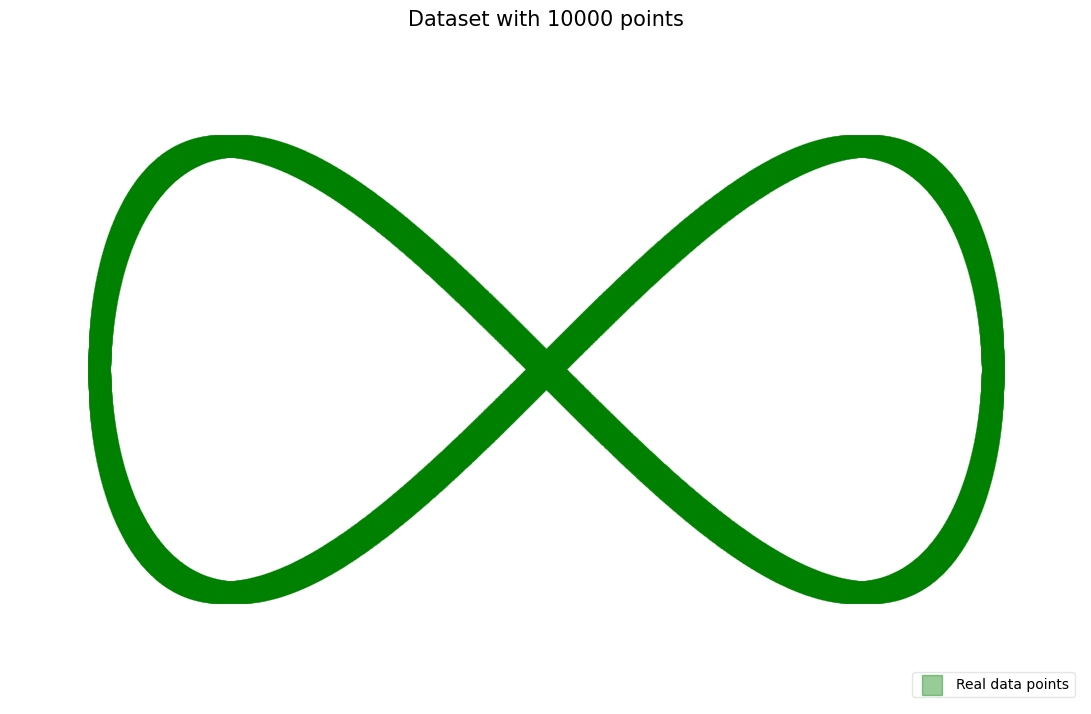

In [8]:
def make_infinity(num_of_points):
    t = np.linspace(0, 2 * np.pi, num_of_points)  # parameter t for smoothness
    x = np.sin(t)  # x coordinates
    y = np.sin(t) * np.cos(t) # y coordinates
    return np.stack([x, y], axis=1)

num_of_points_10k = 10000
num_of_points_20 = 20
num_of_points_142= 142
X_10k = make_infinity(num_of_points_10k)
X_142 = make_infinity(num_of_points_142)

X_10k_torch = torch.tensor(X_10k, dtype=torch.float32)
X_142_torch = torch.tensor(X_142, dtype=torch.float32)

plot_final(None, X_10k, None, title=f"Dataset with {num_of_points_10k} points")


### Diffusion model hyperparameters

Before training, we need to define the noise schedule. 

Here, we define the schedule of variances at different discretization steps.

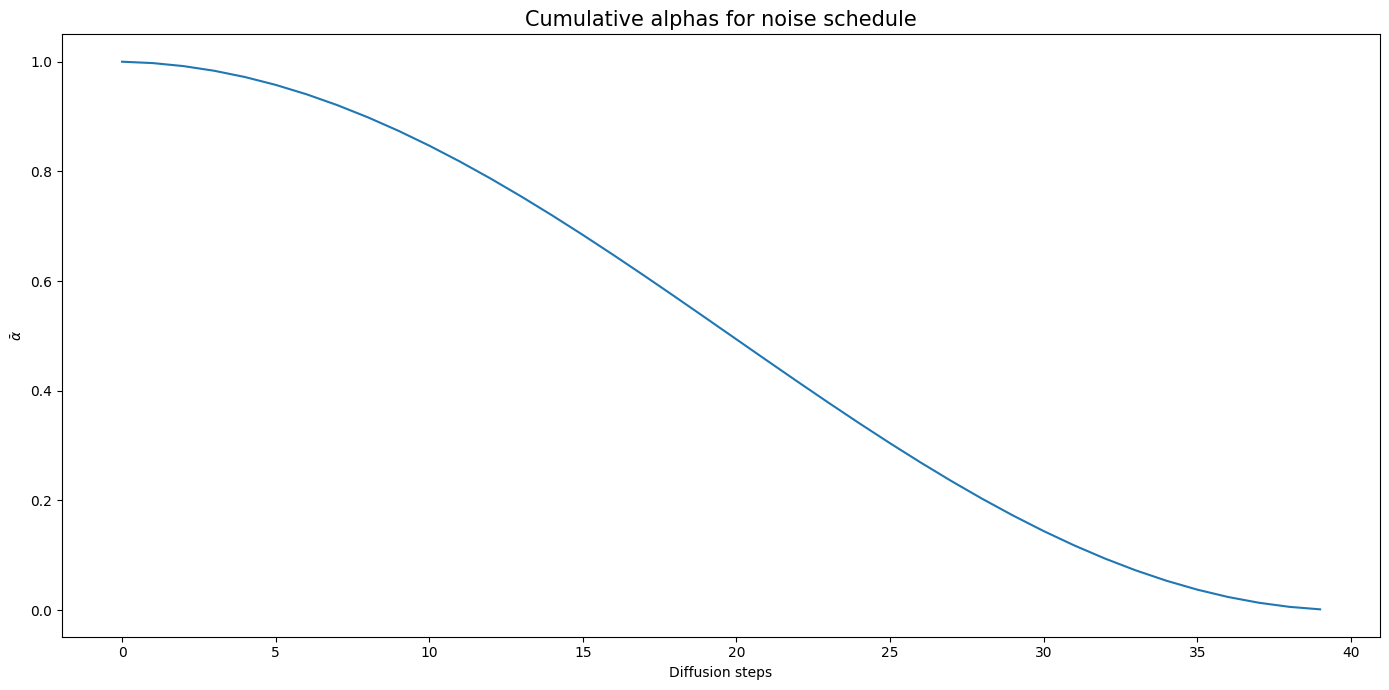

In [9]:
diffusion_steps = 40  # Number of steps in the diffusion process

# Set noising variances betas as in Nichol and Dariwal paper (https://arxiv.org/pdf/2102.09672.pdf)
s = 0.008
timesteps = torch.tensor(range(0, diffusion_steps), dtype=torch.float32)
schedule = torch.cos((timesteps / diffusion_steps + s) / (1 + s) * torch.pi / 2)**2

baralphas = schedule / schedule[0]
betas = 1 - baralphas / torch.concatenate([baralphas[0:1], baralphas[0:-1]])
alphas = 1 - betas


plt.figure(figsize=(figsize_x, figsize_y))
plt.plot(baralphas)
plt.xlabel("Diffusion steps", fontsize=legend_fontsize)
plt.ylabel(r"$\bar{\alpha}$", fontsize=legend_fontsize)
plt.title("Cumulative alphas for noise schedule", fontsize=title_fontsize)
plt.tight_layout()

plt.show()

Function that noises a data point following the forward process

In [10]:
def noise(Xbatch, t):
    eps = torch.randn(size=Xbatch.shape)
    noised = (baralphas[t] ** 0.5).repeat(1, Xbatch.shape[1]) * Xbatch + ((1 - baralphas[t]) ** 0.5).repeat(1, Xbatch.shape[1]) * eps
    return noised, eps

### Visualizing the forward process

Here we show the noised data points $\bar{\mathbf{x}}_{t}$, given the noise schedule above

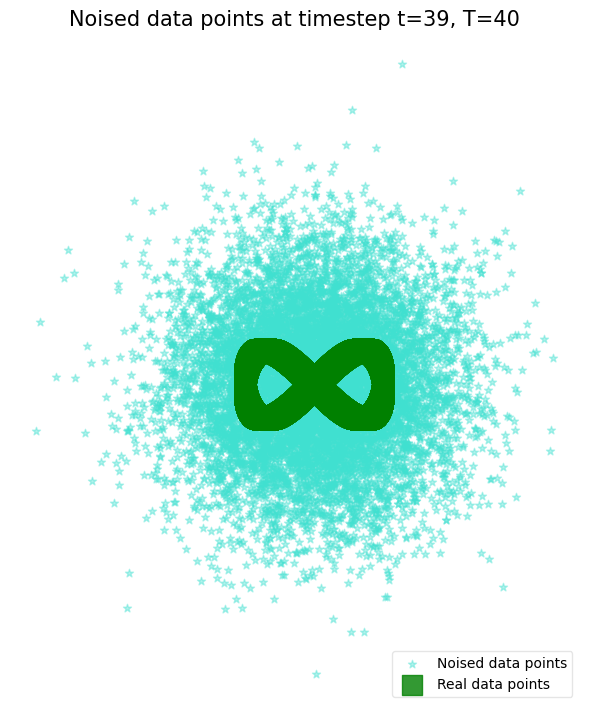

In [15]:
current_timestep = 39

noised, eps = noise(X_10k_torch, torch.full([len(X_10k_torch), 1], fill_value=current_timestep))
fig = plt.figure(figsize=(figsize_x, figsize_y))
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.scatter(noised[:, 0], noised[:, 1], marker="*", alpha=0.4, c="turquoise", label="Noised data points")
plt.scatter(X_10k_torch[:, 0], X_10k_torch[:, 1], label="Real data points", color="green", alpha=0.8, marker="s", s=data_point_size, zorder=10)
plt.title(f"Noised data points at timestep t={current_timestep}, T={diffusion_steps}", fontsize=title_fontsize)
plt.legend(loc=location, fontsize=legend_fontsize, framealpha=0.5)
plt.show()

### Train denoising network

We now define a pytorch network that will learn to predict the noise component from noised data.

In [12]:
import torch.nn as nn

class DiffusionBlock(nn.Module):
    def __init__(self, nunits):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(nunits, nunits)

    def forward(self, x: torch.Tensor):
        x = self.linear(x)
        x = nn.functional.relu(x)
        return x


class DiffusionModel(nn.Module):
    def __init__(self, nfeatures: int, nblocks: int = 2, nunits: int = 64):
        super(DiffusionModel, self).__init__()

        self.inblock = nn.Linear(nfeatures+1, nunits)
        self.midblocks = nn.ModuleList([DiffusionBlock(nunits) for _ in range(nblocks)])
        self.outblock = nn.Linear(nunits, nfeatures)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        val = torch.hstack([x, t])  # Add t to inputs
        val = self.inblock(val)
        for midblock in self.midblocks:
            val = midblock(val)
        val = self.outblock(val)
        return val

Here is the training loop. Run the code snippet below to train the model.

In [13]:
loss_fn = nn.MSELoss()

def train_diffusion_model(X, diffusion_steps, nepochs=2000, batch_size=2048):
    model = DiffusionModel(nfeatures=2, nblocks=4)

    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=nepochs)  

    for epoch in tqdm(range(nepochs), desc=f"Training epochs for dataset with {len(X)} points"):
        epoch_loss = 0
        steps = 0
        for i in range(0, len(X), batch_size):
            Xbatch = X[i:i+batch_size]
            timesteps = torch.randint(0, diffusion_steps, size=[len(Xbatch), 1])
            noised, eps = noise(Xbatch, timesteps)
            predicted_noise = model(noised.to(device), timesteps.to(device))
            loss = loss_fn(predicted_noise, eps.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            steps += 1
        scheduler.step()
    return model


In [14]:
model_10k = train_diffusion_model(X_10k_torch, diffusion_steps)
# model_20 = train_diffusion_model(X_20_torch, diffusion_steps)

Training epochs for dataset with 10000 points: 100%|██████████| 2000/2000 [00:15<00:00, 126.93it/s]


### Test generation

To sample from the learned model, we need to define the sampling procedure (simulating the reverse process).

We will use the classic DDPM sampling procedure, defined as follows:

In [16]:
def sample_ddpm(model, nsamples, nfeatures, intermediate_step=None):
    """
    Runs the usual DDPM backward loop, but also captures the state at one specified timestep.

    Args:
      model: your denoiser, f(x, t) → ϵ̂
      nsamples: number of points to generate
      nfeatures: data dimensionality (e.g. 2)
      intermediate_step: optional int t at which to capture x_t (1 ≤ t ≤ diffusion_steps)

    Returns:
      x_final:        the final cleaned samples (x_0 estimate)
      xt_history:     list of length diffusion_steps, where
                      xt_history[i] is x at t = diffusion_steps - i
      x_intermediate: the x at t=intermediate_step (or None if intermediate_step is None)
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    x = torch.randn(nsamples, nfeatures, device=device)
    input_to_diffusion = x
    # prepare storage
    xt_history = [x]
    x_intermediate = None
    # if user wants the very first noise-level (t = diffusion_steps):
    if intermediate_step == diffusion_steps:
        x_intermediate = x.clone()

    # backward diffusion
    for t in range(diffusion_steps - 1, 0, -1):
        # predict noise
        t_col = torch.full((nsamples, 1), t, device=device, dtype=torch.long)
        predicted_noise = model(x, t_col)

        # denoise
        x = (
            1.0 / alphas[t].sqrt()
            * (x - (1 - alphas[t]) / (1 - baralphas[t]).sqrt() * predicted_noise)
        )
        # add noise for stochasticity (except final step)
        if t > 1:
            x = x + betas[t].sqrt() * torch.randn_like(x)

        # store history
        xt_history.append(x)

        # capture if this is the user’s requested step
        if intermediate_step is not None and t == intermediate_step:
            x_intermediate = x.clone()

    x_final = x
    return x_final, xt_history, x_intermediate, input_to_diffusion


Using the sampling algorithm defined above, we can generate 1500 samples from the trained diffusion model.

(148, 2)


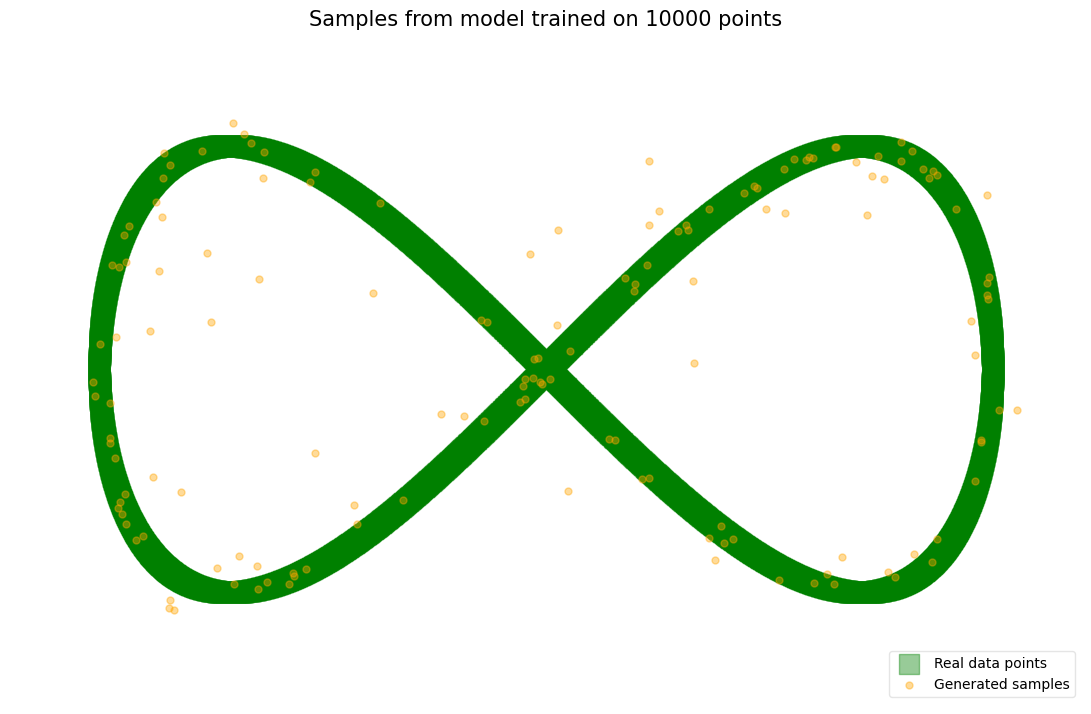

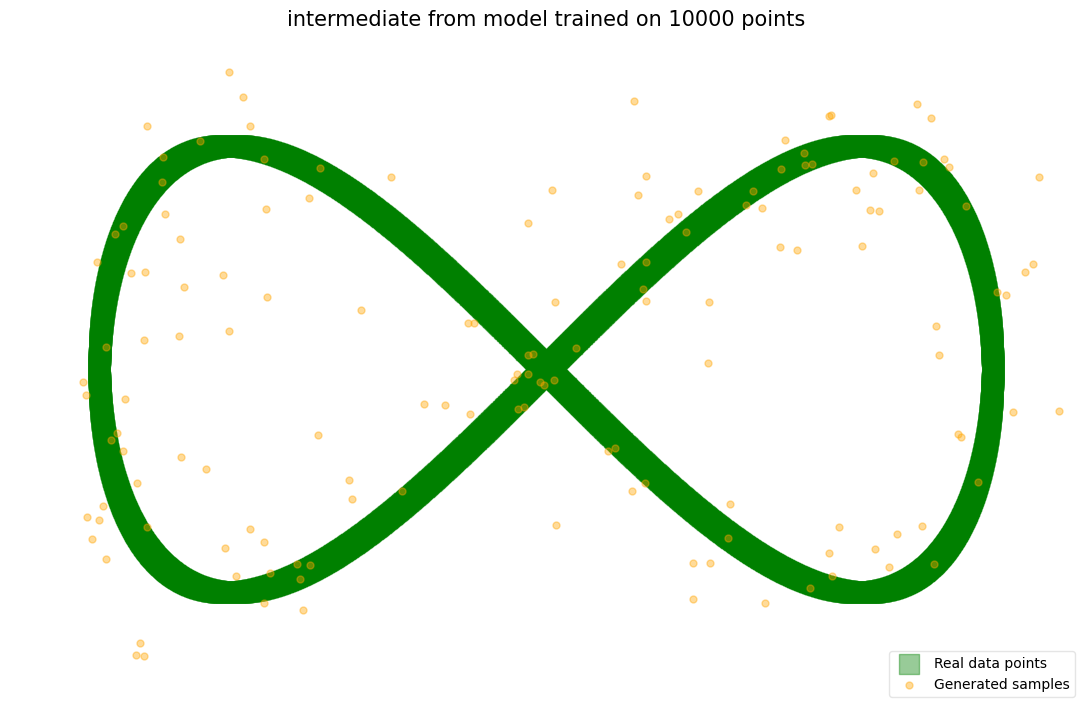

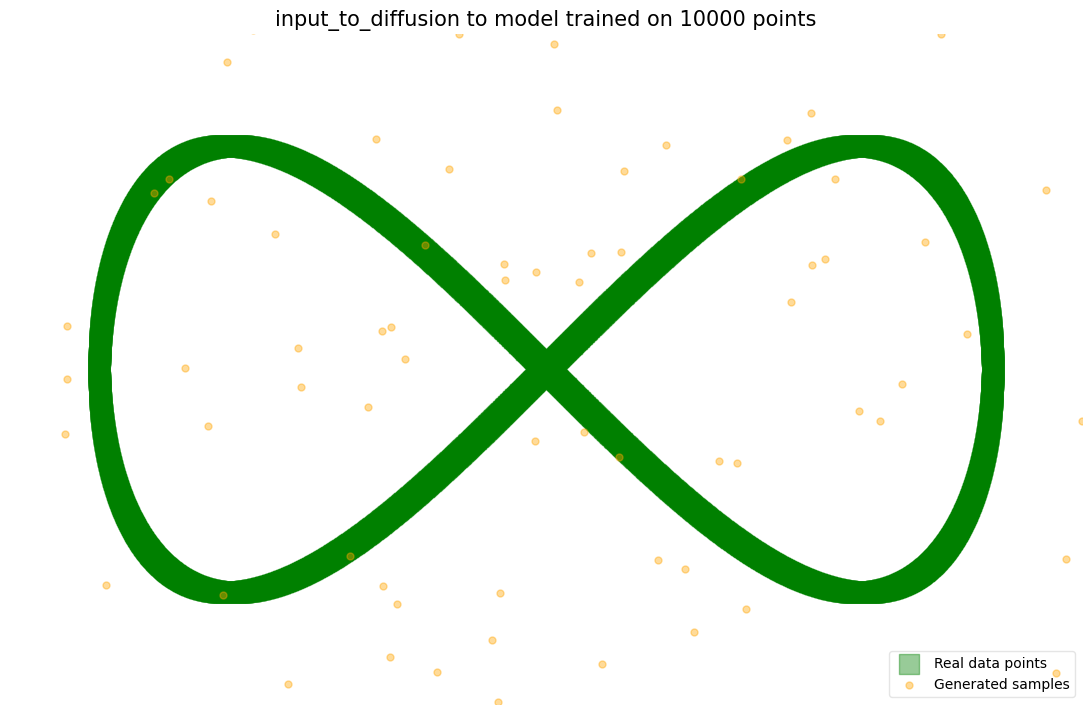

In [17]:
num_points = 148

samples_10k, samples_10k_hist, intermediate, input_to_diffusion = sample_ddpm(model_10k, num_points, 2, 2)
samples_10k_np = samples_10k.cpu().detach().numpy()
intermediate_np = intermediate.cpu().detach().numpy()
input_to_diffusion_np = input_to_diffusion.cpu().detach().numpy()
print(input_to_diffusion_np.shape)


plot_final(samples_10k_np, X_10k, None, title=f"Samples from model trained on {num_of_points_10k} points")
plot_final(intermediate_np, X_10k, None, title=f"intermediate from model trained on {num_of_points_10k} points")
plot_final(input_to_diffusion_np, X_10k, None, title=f"input_to_diffusion to model trained on {num_of_points_10k} points")

In [ ]:
xmin, xmax = -6, 6
ymin, ymax = -6, 6
data_point_size = 50
nn_point_size = 50
generated_point_size = 50
legend_fontsize = 12
frameon = True
figsize = 8

def plot_data(sampler=None, data_points=None, zs=None, selected_z=None, title=None, f_name=None, arrow=False, eps=0.0):

    plt.figure(figsize=(figsize, figsize))
    if data_points is not None:
        plt.scatter(data_points[:, 0], data_points[:, 1], label="Real data points", color="blue", marker="s", s=data_point_size)
        if eps > 0.0:
            for center in data_points:
                circle = plt.Circle(center, eps, fill=True, alpha=0.2, linestyle="--", edgecolor="black", facecolor="gray")
                plt.gca().add_patch(circle)

    if sampler is not None:
        if zs is not None:
            generated = sampler(zs).detach()
            plt.scatter(generated[:, 0], generated[:, 1], label="Generated samples", color="orange", alpha=0.5, marker=".", s=generated_point_size)
    
    generated_np = generated.cpu().detach().numpy()

    plot_final(generated_np, data_points, None, title=f"IMLE model that has been trained on {num_points} points")

# Implicit Model

In [28]:
lr = 0.01               # learning rate
noise_coef = 0.000001   # additive noise coeficient for perturbing the samples
epochs = 30000          # number of passes over the data
staleness = 20          # number of passes over the data before new samples are drawn
sample_factor = 10      # number of samples to draw

eval_batch_size = 1000
save_images_step = 5000

In [19]:
def imle_sampler(model):
    def sample_fn(z):
        model.eval()
        sample = model(z)
        return sample
    return sample_fn

# set up where condition is added as a contacanation

### Just simple contacation 

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# ---------- 1.  FINAL “PRETTY” FIGURE ---------------------------------
def plot_final_with_device(generated=None, data_points=None, gmm=None,
                           title=None, f_name=None):
    fig = plt.figure(figsize=(figsize_x, figsize_y))
    plt.gca().set_aspect("equal", adjustable="box")
    fig.patch.set_alpha(0.0)
    plt.axis("off")
    plt.ylim(-y_lim, y_lim)
    plt.xlim(-x_lim, x_lim)
    plt.tight_layout()

    # convert everything to CPU → NumPy
    if data_points is not None and torch.is_tensor(data_points):
        data_points = data_points.detach().cpu().numpy()
    if generated is not None and torch.is_tensor(generated):
        generated = generated.detach().cpu().numpy()

    if data_points is not None:
        plt.scatter(data_points[:, 0], data_points[:, 1],
                    label="Real data points",
                    color="green", alpha=0.4, marker="s",
                    s=data_point_size)

    if generated is not None:
        plt.scatter(generated[:, 0], generated[:, 1],
                    label="Generated samples",
                    color="orange", alpha=0.4, marker=".",
                    s=generated_point_size, zorder=10)

    if gmm is not None:
        levels = np.arange(0, 1, 0.1)
        grid_space = 100
        x_grid = torch.linspace(-x_lim, x_lim, grid_space).cpu().numpy()
        y_grid = torch.linspace(-y_lim, y_lim, grid_space).cpu().numpy()
        X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
        XY = np.array([X_grid.ravel(), Y_grid.ravel()]).T
        Z = np.exp(gmm.score_samples(XY)).reshape(X_grid.shape).clip(0, 1)
        plt.contourf(X_grid, Y_grid, Z, cmap="Blues",
                     alpha=0.5, levels=levels, extend="both")
        contours = plt.contour(X_grid, Y_grid, Z,
                               levels=levels, colors="black", linewidths=1.0)
        plt.clabel(contours, inline=True, fontsize=legend_fontsize)

    plt.legend(loc=location, fontsize=legend_fontsize, framealpha=0.5)
    if title is not None:
        plt.title(title, fontsize=title_fontsize)

    if f_name:
        fmt = "png" if f_name.endswith(".png") else "pdf"
        plt.savefig(f_name, format=fmt, bbox_inches="tight", transparent=True)
    else:
        display(fig)          # Jupyter/IPython
    plt.close()

import os, torch, numpy as np
from tqdm import tqdm

def make_infinity(num_of_points):
    t = np.linspace(0, 2 * np.pi, num_of_points)
    x = np.sin(t)
    y = np.sin(t) * np.cos(t)
    return np.stack([x, y], axis=1)

# ---------- 2.  QUICK “DEBUG” PLOT DURING TRAINING --------------------
def plot_data_with_device(sampler=None, data_points=None,
                          zs=None, selected_z=None,
                          title=None, f_name=None,
                          arrow=False, eps=0.0):

    plt.figure(figsize=(figsize, figsize))

    # --- real data (green squares) ---
    if data_points is not None:
        dp_np = (data_points.detach().cpu().numpy()
                 if torch.is_tensor(data_points) else data_points)
        plt.scatter(dp_np[:, 0], dp_np[:, 1],
                    label="Real data points",
                    color="blue", marker="s", s=data_point_size)
        if eps > 0:
            for c in dp_np:
                circle = plt.Circle(c, eps, fill=True, alpha=0.2,
                                    edgecolor="black", facecolor="gray",
                                    linestyle="--")
                plt.gca().add_patch(circle)

    # --- generated samples (orange dots) ---
    generated_np = None
    if sampler is not None and zs is not None:
        gen = sampler(zs).detach()
        generated_np = gen.cpu().numpy()
        plt.scatter(generated_np[:, 0], generated_np[:, 1],
                    label="Generated samples",
                    color="orange", alpha=0.5, marker=".",
                    s=generated_point_size)

    # If you want arrows / selected neighbours, do the same CPU conversion
    # for selected_z and selected.

    # Pretty wrapper using the nicer function:
    plot_final_with_device(generated_np, data_points, None,
                           title=(title or "IMLE"), f_name=None)

    if f_name:
        plt.savefig(f_name, bbox_inches="tight")
        plt.close()
    else:
        plt.show()

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Generator_cond(nn.Module):
    def __init__(
        self,
        nfeatures: int,
        nblocks: int = 2,
        nunits:   int = 64,
        *,
        t_mode:  str = "given",    # "none" | "given" | "learnable" | "random"
        t_init:  float = 20.0,     # only used if t_mode="learnable"
        max_t:   int   = 40        # only used if t_mode="random"
    ):
        super().__init__()
        assert t_mode in ("none", "given", "learnable", "random")
        self.t_mode = t_mode
        self.max_t  = max_t

        # If we're learning a global t, register a scalar parameter:
        if t_mode == "learnable":
            # initialize so its value starts at 20. 
            # we'll treat it as a float and expand to [B,1] in forward.
            self.t_param = nn.Parameter(torch.tensor(float(t_init)))

        # **Where “dimension of val” is chosen**: 
        #   whichever mode, the input to inblock is: 
        #     - nfeatures      if t_mode="none"
        #     - nfeatures + 1  otherwise
        dim_in = nfeatures * 2 + (0 if t_mode=="none" else 1)
        self.inblock   = nn.Linear(dim_in, nunits)
        self.midblocks = nn.ModuleList([DiffusionBlock(nunits) for _ in range(nblocks)])
        self.outblock  = nn.Linear(nunits, nfeatures)

    def forward(self, x: torch.Tensor, t: torch.Tensor = None) -> torch.Tensor:
        """
        x: [B, nfeatures]
        t: [B, 1]    only used if t_mode="given"
        """
        B = x.shape[0]

        # --- assemble the input vector val of shape [B, dim_in] ---
        if self.t_mode == "none":
            val = x

        elif self.t_mode == "given":
            if t is None:
                raise ValueError("t_mode='given' requires passing t of shape [B,1]")
            val = torch.cat([x, t], dim=-1)

        elif self.t_mode == "learnable":
            # expand the single scalar into [B,1]
            tval = self.t_param.view(1,1).expand(B, 1)
            val = torch.cat([x, tval], dim=-1)

        elif self.t_mode == "random":
            # sample uniform integers in [0, max_t)
            t_int = torch.randint(0, self.max_t, (B,1),
                                  device=x.device).to(x.dtype)
            val = torch.cat([x, t_int], dim=-1)

        # --- pass through the MLP ---
        val = self.inblock(val)
        val = F.relu(val)
        for block in self.midblocks:
            val = block(val)
        out = self.outblock(val)
        return out

In [23]:
def find_nn(data_point, generated):
    dists = torch.sum((generated - data_point)**2, dim=1)
    dists = dists**0.5
    return torch.argmin(dists).item()

### Instantiate models

In [ ]:
# # no t at all
# model0 = Generator(nfeatures=2, t_mode="none")


# # learn a single global t, starting from 20.0
# model2 = Generator(nfeatures=2, t_mode="learnable", t_init=20.0)

# sample t ∈ [0,39] each forward pass


### train stage 1

In [ ]:
import os
num_points = 142
#intermediate
# input_to_diffusion is my condition
imle_model = Generator_cond(nfeatures=2, t_mode="random", max_t=40)
# Now write it based on that (those two variables have been already assigned just use them 
# intermediate, input_to_diffusion 
def make_infinity(num_of_points):
    t = np.linspace(0, 2 * np.pi, num_of_points)  # parameter t for smoothness
    x = np.sin(t)  # x coordinates
    y = np.sin(t) * np.cos(t) # y coordinates
    return np.stack([x, y], axis=1)
data = make_infinity(num_points)
data = torch.tensor(data, dtype=torch.float32)

zdim = 2  # latent space dimension
# imle_model = Generator(n_mlp=4, in_dim=zdim, hidden_dim=32)
optimizer = torch.optim.Adam(imle_model.parameters(), lr=lr)
n = 142
imle_nn_z = torch.randn(n, zdim)
nz = data.shape[0]*sample_factor
print(nz)
plots_dir = f"imle/plots"
os.makedirs(plots_dir, exist_ok=True)

print("Training vanilla IMLE model...")
progress_bar = tqdm(total=epochs)

for e in range(epochs):
    with torch.no_grad():
        if e % staleness == 0:
            imle_model.eval()
            zs = torch.randn(nz, zdim)
            generated = imle_model(zs).detach()

            ## If the dataset or sample_factor is large, find_nn is extremely slow.
            ## It's better to use a k-NN search library here,
            ## e.g., https://github.com/niopeng/dciknn_cuda
            ## If the dataset is large, you should use mini-batches to
            ## avoid going over the entire dataset at once.
            nns = torch.tensor([find_nn(d, generated) for d in data], dtype=torch.long)
            imle_nn_z = zs[nns] + torch.randn(nns.shape[0], zdim) * noise_coef
        if e % save_images_step == 0:
            plot_data(sampler=imle_sampler(imle_model), data_points=data, zs=zs, selected_z=imle_nn_z, title=f"Vanilla IMLE Training", f_name=f"{plots_dir}/imle-epoch-{e:05}.png", arrow=True)

    imle_model.train()
    optimizer.zero_grad()
    outs = imle_model(imle_nn_z)
    dists = torch.sum((outs - data)**2, dim=1)

    loss = dists.mean()
    loss.backward()
    optimizer.step()

    progress_bar.update(1)
    logs = {"loss": loss.detach().item(), "step": e}
    progress_bar.set_postfix(**logs)

progress_bar.close()

zs = torch.randn(eval_batch_size, zdim)
# plot_data(sampler=imle_sampler(imle_model), zs=zs, title="Vanilla IMLE Final Samples", f_name=f"{plots_dir}/imle-final.png")
plot_data(sampler=imle_sampler(imle_model),  data_points=data, zs=zs, title="Vanilla IMLE Final Samples")



In [ ]:
stage2_data = torch.tensor(make_infinity(data.shape[0]),
                           dtype=torch.float32, device=device)
conds2      = torch.zeros(stage2_data.shape[0], cond_dim, device=device)
imle_nn_z2  = torch.randn(stage2_data.shape[0], zdim, device=device)

progress_bar = tqdm(total=epochs)
for e in range(epochs):
    with torch.no_grad():
        if e % staleness == 0:
            imle_model.eval()
            zs_all   = torch.randn(stage2_data.shape[0] * m, zdim, device=device)
            conds_all = conds2.unsqueeze(1).repeat(1, m, 1).view(-1, cond_dim)
            inputs_all = torch.cat([conds_all, zs_all], dim=1)
            generated_all = imle_model(x=zs_all, cond=conds_all).detach() \
                                .view(stage2_data.shape[0], m, -1)
            dists = ((generated_all - stage2_data.unsqueeze(1)) ** 2).sum(-1)
            nn_idx = dists.argmin(1)
            base = torch.arange(stage2_data.shape[0],  device=device) * m
            imle_nn_z2 = zs_all[base + nn_idx] + torch.randn_like(imle_nn_z2) * noise_coef
    imle_model.train()
    optimizer.zero_grad()
    outs = imle_model(x=imle_nn_z2, cond=conds2)    
    loss = ((outs - stage2_data) ** 2).sum(1).mean()
    loss.backward()
    optimizer.step()
    progress_bar.update(1)
    progress_bar.set_postfix(loss=loss.item(), step=e)
progress_bar.close()

plot_data_with_device(sampler=imle_sampler(imle_model),
                      data_points=stage2_data,
                      zs=zs_all,
                      title="Stage‑2 distillation")


### Concatenate and project (similar to the original cIMLE trick)

# no conditions

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Generator_no_cond(nn.Module):
    def __init__(
        self,
        nfeatures: int,
        nblocks: int = 2,
        nunits:   int = 64,
        *,
        t_mode:  str = "given",    # "none" | "given" | "learnable" | "random"
        t_init:  float = 20.0,     # only used if t_mode="learnable"
        max_t:   int   = 40        # only used if t_mode="random"
    ):
        super().__init__()
        assert t_mode in ("none", "given", "learnable", "random")
        self.t_mode = t_mode
        self.max_t  = max_t

        # If we're learning a global t, register a scalar parameter:
        if t_mode == "learnable":
            # initialize so its value starts at 20. 
            # we'll treat it as a float and expand to [B,1] in forward.
            self.t_param = nn.Parameter(torch.tensor(float(t_init)))

        # **Where “dimension of val” is chosen**: 
        #   whichever mode, the input to inblock is: 
        #     - nfeatures      if t_mode="none"
        #     - nfeatures + 1  otherwise
        dim_in = nfeatures + (0 if t_mode=="none" else 1)
        self.inblock   = nn.Linear(dim_in, nunits)
        self.midblocks = nn.ModuleList([DiffusionBlock(nunits) for _ in range(nblocks)])
        self.outblock  = nn.Linear(nunits, nfeatures)

    def forward(self, x: torch.Tensor, t: torch.Tensor = None) -> torch.Tensor:
        """
        x: [B, nfeatures]
        t: [B, 1]    only used if t_mode="given"
        """
        B = x.shape[0]

        # --- assemble the input vector val of shape [B, dim_in] ---
        if self.t_mode == "none":
            val = x

        elif self.t_mode == "given":
            if t is None:
                raise ValueError("t_mode='given' requires passing t of shape [B,1]")
            val = torch.cat([x, t], dim=-1)

        elif self.t_mode == "learnable":
            # expand the single scalar into [B,1]
            tval = self.t_param.view(1,1).expand(B, 1)
            val = torch.cat([x, tval], dim=-1)

        elif self.t_mode == "random":
            # sample uniform integers in [0, max_t)
            t_int = torch.randint(0, self.max_t, (B,1),
                                  device=x.device).to(x.dtype)
            val = torch.cat([x, t_int], dim=-1)

        # --- pass through the MLP ---
        val = self.inblock(val)
        val = F.relu(val)
        for block in self.midblocks:
            val = block(val)
        out = self.outblock(val)
        return out

1420
Training vanilla IMLE model...


  0%|          | 0/30000 [00:00<?, ?it/s]

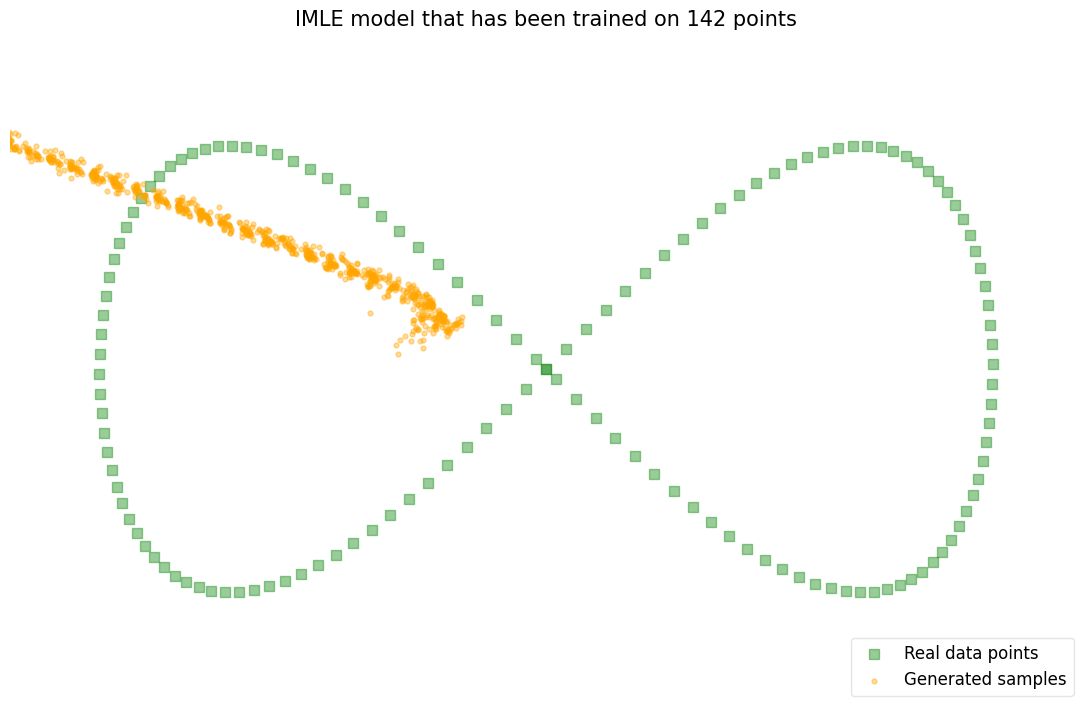

 17%|█▋        | 5000/30000 [00:07<00:34, 718.28it/s, loss=0.000131, step=4999]

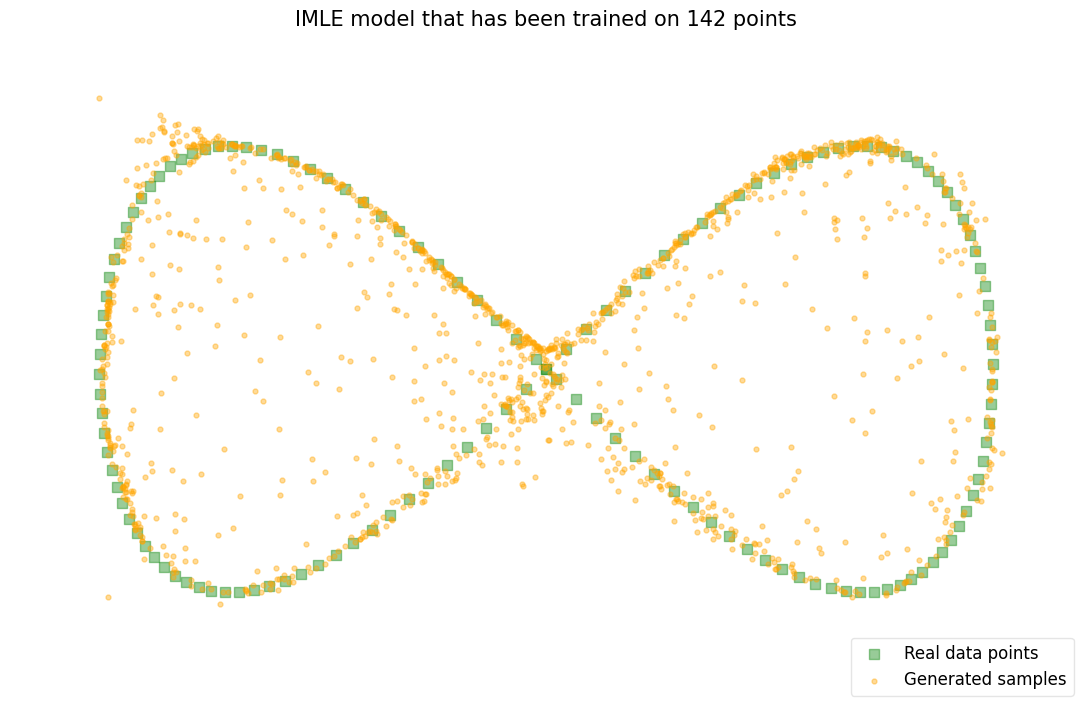

 33%|███▎      | 10000/30000 [00:14<00:28, 710.24it/s, loss=4.45e-5, step=9999]

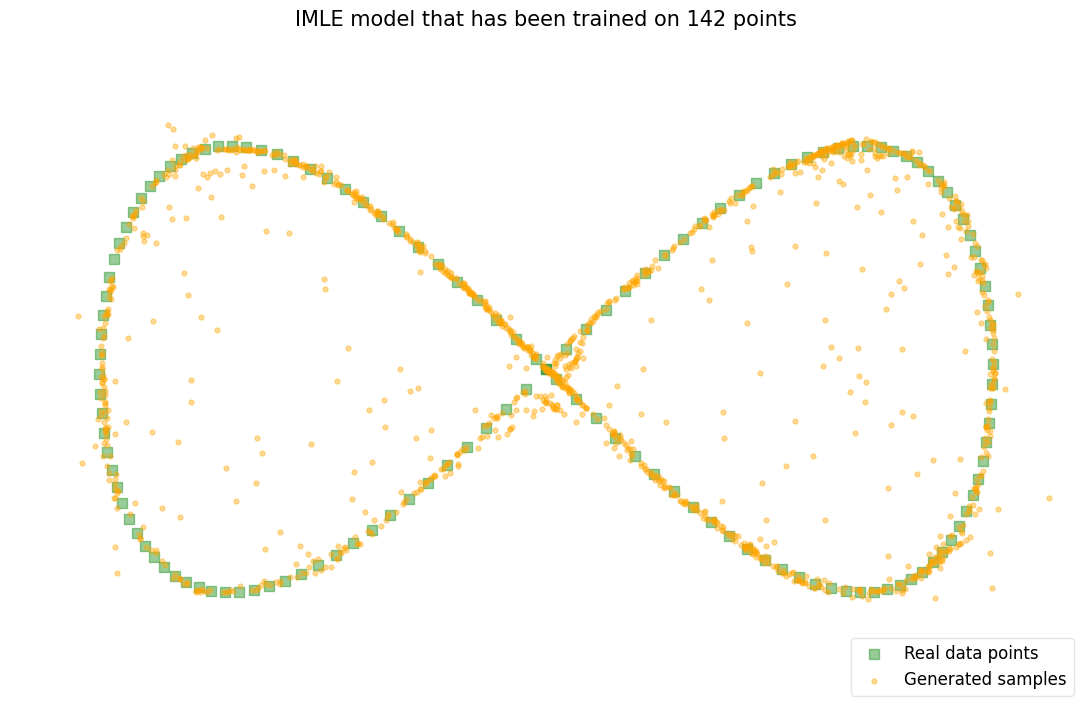

 50%|█████     | 15000/30000 [00:21<00:20, 715.15it/s, loss=0.000156, step=14999]

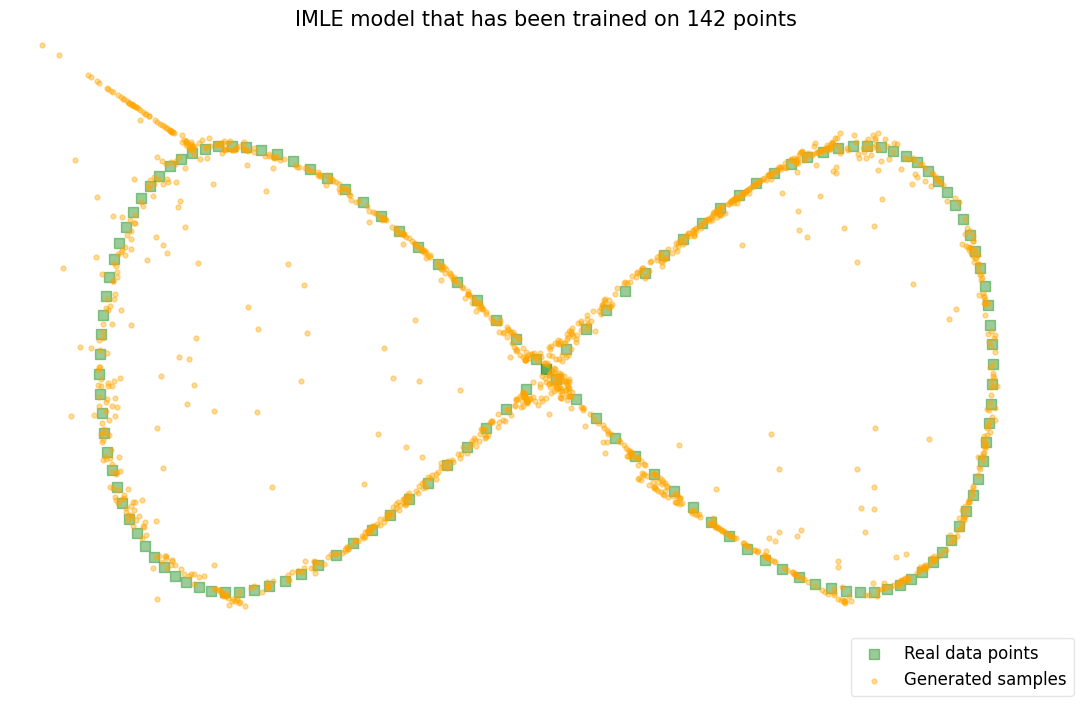

 67%|██████▋   | 20000/30000 [00:28<00:14, 703.90it/s, loss=3.96e-5, step=2e+4]  

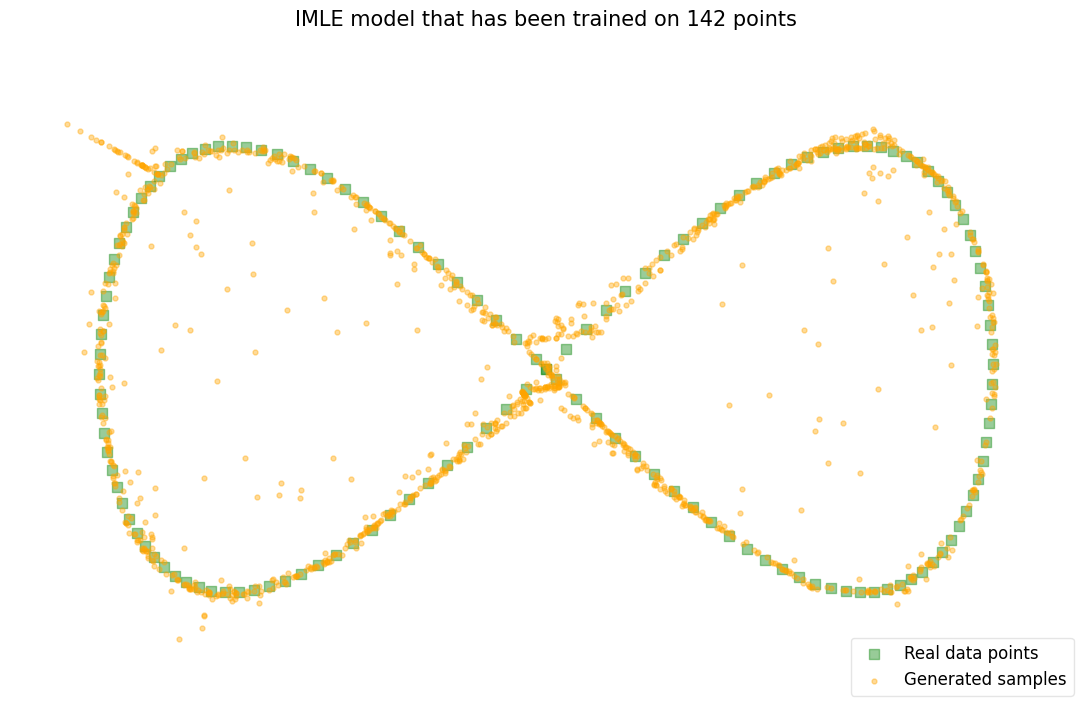

 83%|████████▎ | 25000/30000 [00:35<00:07, 682.36it/s, loss=3.47e-5, step=24999] 

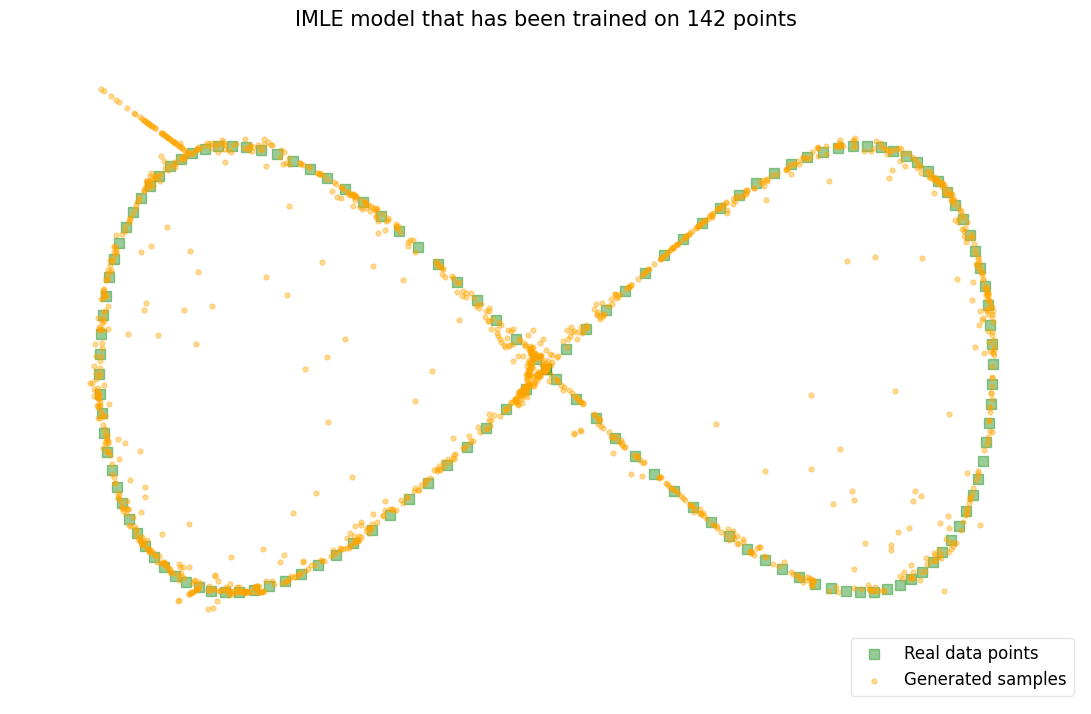

100%|██████████| 30000/30000 [00:43<00:00, 695.74it/s, loss=4.76e-5, step=3e+4]  


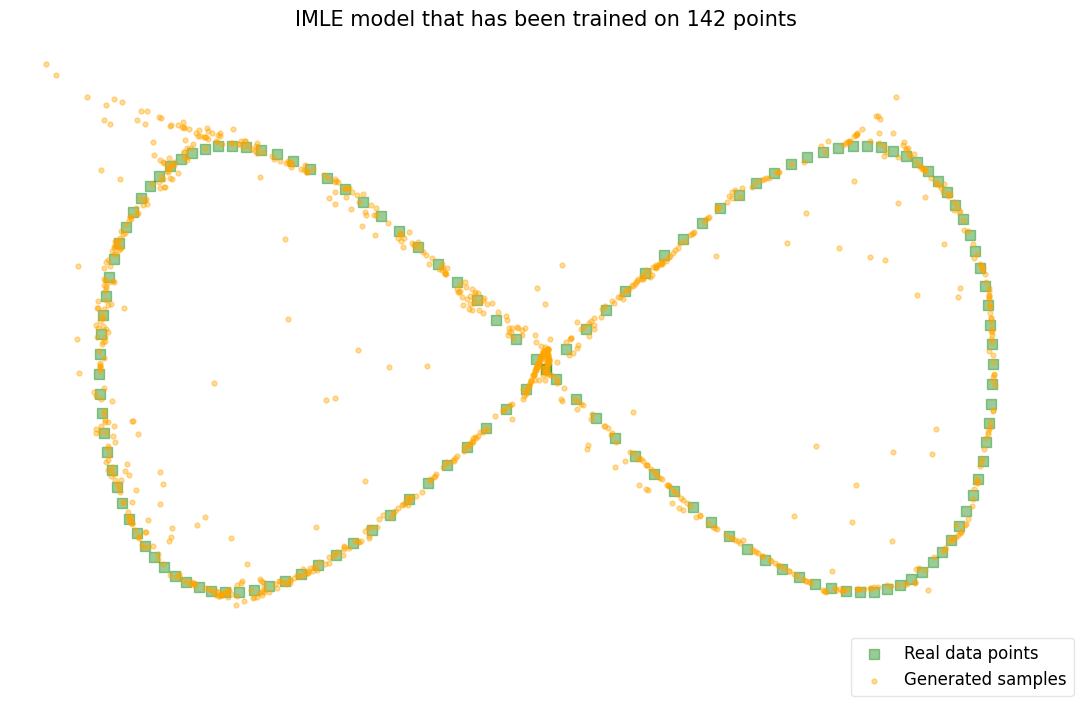

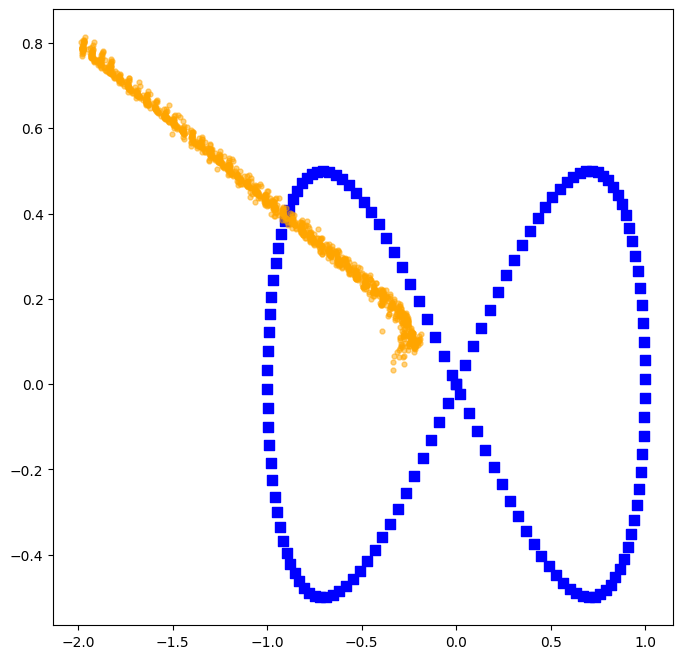

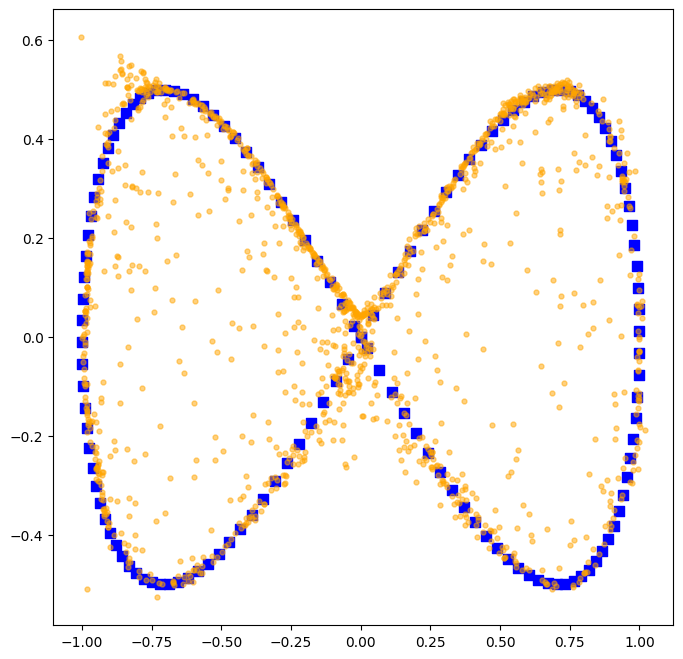

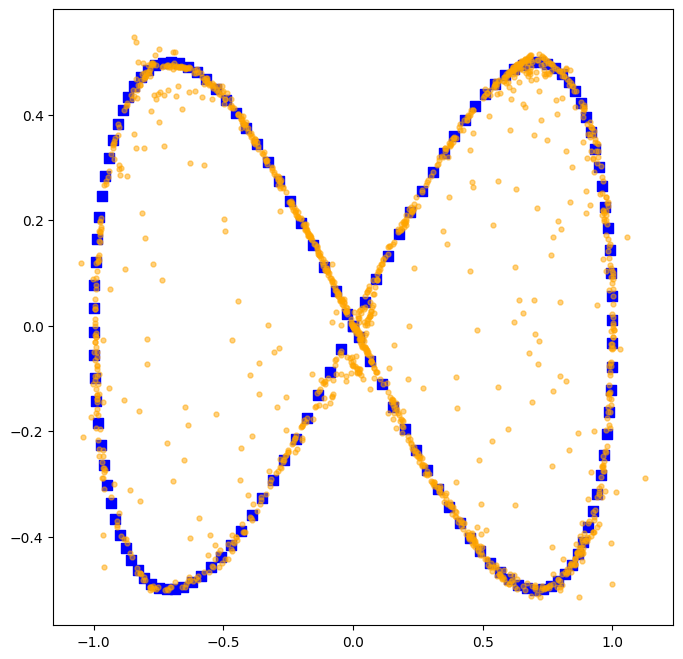

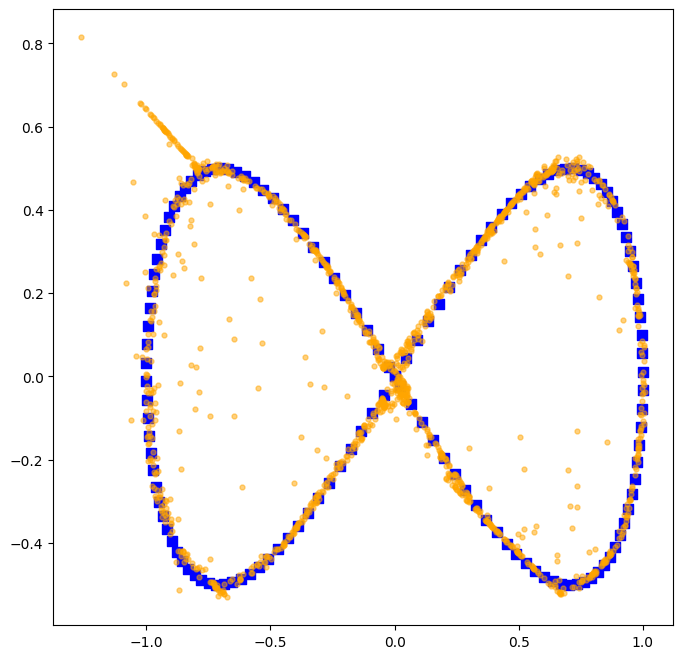

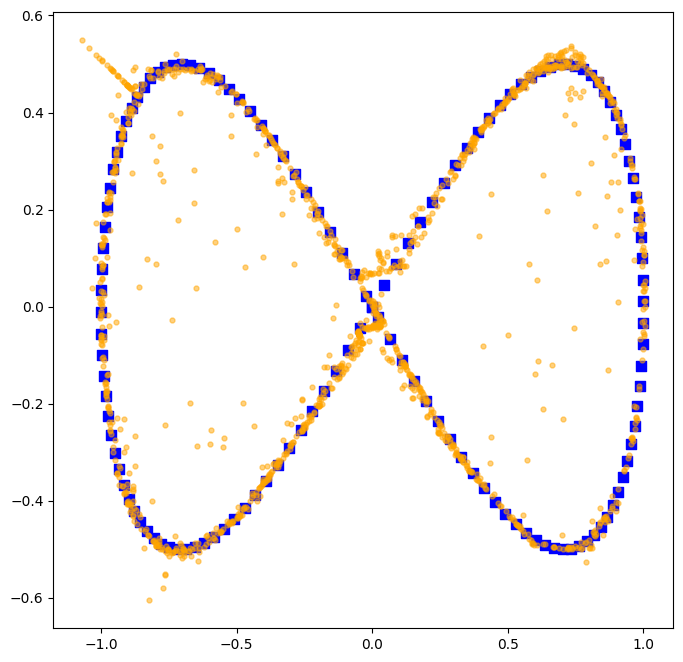

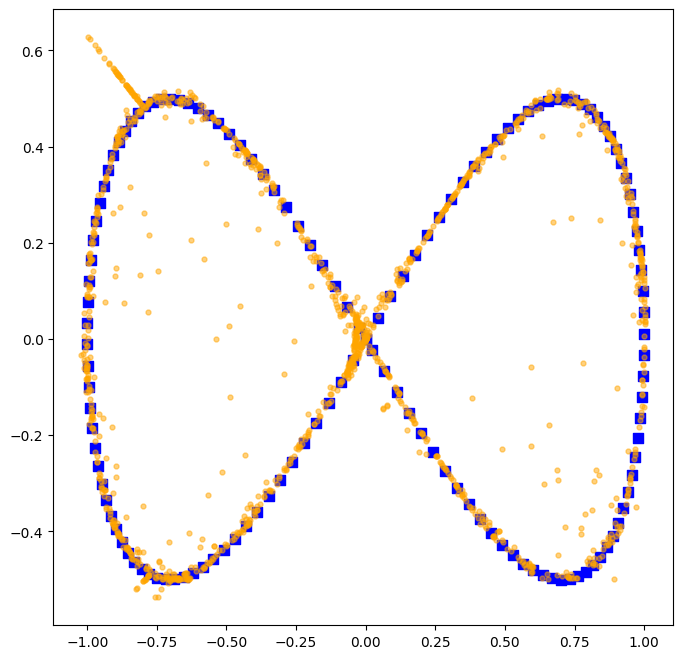

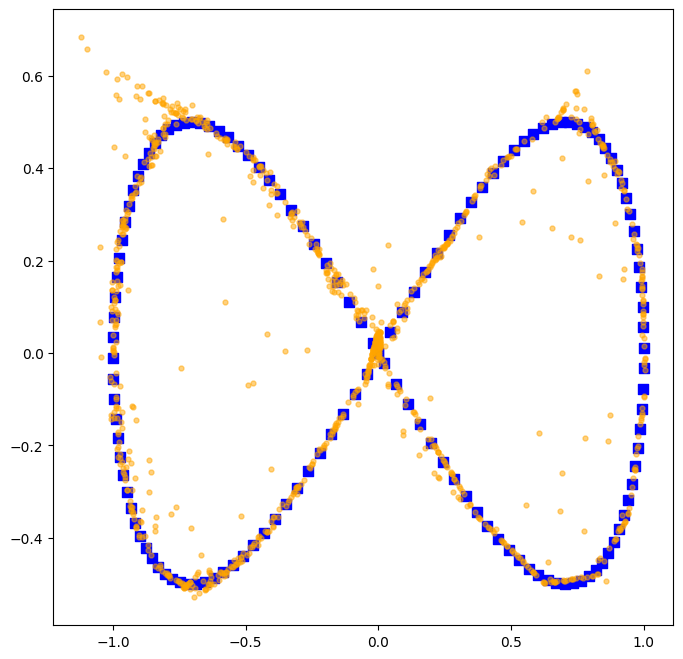

In [ ]:
import os
num_points = 142

# input_to_diffusion is my condition
imle_model = Generator_no_cond(nfeatures=2, t_mode="random", max_t=40)
# Now write it based on that (those two variables have been already assigned just use them 
# intermediate, input_to_diffusion 
def make_infinity(num_of_points):
    t = np.linspace(0, 2 * np.pi, num_of_points)  # parameter t for smoothness
    x = np.sin(t)  # x coordinates
    y = np.sin(t) * np.cos(t) # y coordinates
    return np.stack([x, y], axis=1)
data = make_infinity(num_points)
data = torch.tensor(data, dtype=torch.float32)

zdim = 2  # latent space dimension
# imle_model = Generator(n_mlp=4, in_dim=zdim, hidden_dim=32)
optimizer = torch.optim.Adam(imle_model.parameters(), lr=lr)
n = 142
imle_nn_z = torch.randn(n, zdim)
nz = data.shape[0]*sample_factor
print(nz)
plots_dir = f"imle/plots"
os.makedirs(plots_dir, exist_ok=True)

print("Training vanilla IMLE model...")
progress_bar = tqdm(total=epochs)

for e in range(epochs):
    with torch.no_grad():
        if e % staleness == 0:
            imle_model.eval()
            zs = torch.randn(nz, zdim)
            generated = imle_model(zs).detach()

            ## If the dataset or sample_factor is large, find_nn is extremely slow.
            ## It's better to use a k-NN search library here,
            ## e.g., https://github.com/niopeng/dciknn_cuda
            ## If the dataset is large, you should use mini-batches to
            ## avoid going over the entire dataset at once.
            nns = torch.tensor([find_nn(d, generated) for d in data], dtype=torch.long)
            imle_nn_z = zs[nns] + torch.randn(nns.shape[0], zdim) * noise_coef
        if e % save_images_step == 0:
            plot_data(sampler=imle_sampler(imle_model), data_points=data, zs=zs, selected_z=imle_nn_z, title=f"Vanilla IMLE Training", f_name=f"{plots_dir}/imle-epoch-{e:05}.png", arrow=True)

    imle_model.train()
    optimizer.zero_grad()
    outs = imle_model(imle_nn_z)
    dists = torch.sum((outs - data)**2, dim=1)

    loss = dists.mean()
    loss.backward()
    optimizer.step()

    progress_bar.update(1)
    logs = {"loss": loss.detach().item(), "step": e}
    progress_bar.set_postfix(**logs)

progress_bar.close()

zs = torch.randn(eval_batch_size, zdim)
# plot_data(sampler=imle_sampler(imle_model), zs=zs, title="Vanilla IMLE Final Samples", f_name=f"{plots_dir}/imle-final.png")
plot_data(sampler=imle_sampler(imle_model),  data_points=data, zs=zs, title="Vanilla IMLE Final Samples")

In [ ]:
def find_nn_rsimle(data_point, generated, limit = 1e-3):
    l2_distances = np.linalg.norm(generated[:, np.newaxis] - data_point , axis=2)
    to_exclude = l2_distances < limit
    bad_samples_list = np.expand_dims(to_exclude.any(axis=1),-1)
    bad_samples_list_repeated = np.tile(bad_samples_list,to_exclude.shape[1])
    l2_distances[bad_samples_list_repeated] = np.inf
    result = np.argmin(l2_distances,axis=0)
    return result

In [ ]:
distance_threshold = 6e-2   # Epsilon to reject samples

In [ ]:
import os
zdim = 2  # latent space dimension
rsimle_model = model3
optimizer = torch.optim.Adam(rsimle_model.parameters(), lr=lr)
n = data.shape[0]
data = X_142_torch

imle_nn_z = torch.randn(n, zdim)
nz = data.shape[0]*sample_factor
plots_dir = f"rsimle/plots"
os.makedirs(plots_dir, exist_ok=True)

print("Training RS-IMLE model...")
progress_bar = tqdm(total=epochs)

for e in range(epochs):
    with torch.no_grad():
        if e % staleness == 0:
            rsimle_model.eval()
            zs = torch.randn(nz, zdim)
            generated = rsimle_model(zs).detach()

            ## If the dataset or sample_factor is large, find_nn is extremely slow.
            ## It's better to use a k-NN search library here,
            ## e.g., https://github.com/niopeng/dciknn_cuda
            ## If the dataset is large, you should use mini-batches to
            ## avoid going over the entire dataset at once.
            nns = torch.tensor(find_nn_rsimle(data, generated, limit=distance_threshold), dtype=torch.long)
            imle_nn_z = zs[nns] + torch.randn(nns.shape[0], zdim) * noise_coef

        if e % save_images_step == 0:
            plot_data(sampler=imle_sampler(rsimle_model), data_points=data, zs=zs, selected_z=imle_nn_z, title=f"RS-IMLE Training", f_name=f"{plots_dir}/rsimle-epoch-{e:05}.png", arrow=True, eps=distance_threshold)

    rsimle_model.train()
    optimizer.zero_grad()
    outs = rsimle_model(imle_nn_z)
    dists = torch.sum((outs - data)**2, dim=1)
    loss = dists.mean()
    loss.backward()
    optimizer.step()

    progress_bar.update(1)
    logs = {"loss": loss.detach().item(), "step": e}
    progress_bar.set_postfix(**logs)

progress_bar.close()

zs = torch.randn(eval_batch_size, zdim)
plot_data(sampler=imle_sampler(rsimle_model), zs=zs, title="RS-IMLE Final Samples", f_name=f"{plots_dir}/rsimle-final.png")
plot_data(sampler=imle_sampler(rsimle_model), zs=zs, title="RS-IMLE Final Samples")

### Plotting marginal likelihood under the forward process

Recall that the marginal likelihood under the forward process is given by a Gaussian Mixture Model.

We fit an isotropic GMM to the noised data points for a paticular discretization timestep.

In [ ]:
def get_contour(Xbatch, t):

   X_batch = Xbatch
   baralphas_np = baralphas.detach().numpy()
   n_components = X_batch.shape[0]
   gmm = GaussianMixture(n_components=n_components, covariance_type='spherical')

   # Manually set the parameters
   gmm.means_ = (baralphas_np[t] ** 0.5) * X_batch
   gmm.covariances_ = ((1 - baralphas_np[t])) * np.ones(n_components)
   gmm.weights_ = np.ones(n_components) / n_components

   # For spherical, precisions_ is the inverse of variances
   gmm.precisions_ = 1 / gmm.covariances_
   gmm.precisions_cholesky_ = np.sqrt(gmm.precisions_)
   gmm.converged_ = True
   return gmm

In [ ]:
current_timestep = 2
gmm_10k = get_contour(X_10k, t=current_timestep)
plot_final(None, X_10k, gmm_10k, title=f"Contour plot for marginal likelihood for {num_of_points_10k} data points. t={current_timestep}, T={diffusion_steps}",)


In [ ]:
gmm_20 = get_contour(X_20, t=current_timestep)
plot_final(None, X_20, gmm_20, title=f"Contour plot for marginal likelihood for {num_of_points_20} data points. t={current_timestep}, T={diffusion_steps}")
